In [41]:
import pandas as pd
import sys  
sys.path.insert(0, '../scripts')
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import clean_data
import loading_data
import visualize
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [3]:
# load data
df_store = loading_data.load_csv('../data/store.csv')
df_train = loading_data.load_csv('../data/train.csv')
df_test = loading_data.load_csv('../data/test.csv')
df_submission = loading_data.load_csv('../data/sample_submission.csv')

/home/dibora/Pharmaceutical-Sales-prediction-across-multiple-stores/pharmaceutical/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  
/home/dibora/Pharmaceutical-Sales-prediction-across-multiple-stores/pharmaceutical/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  This is separate from the ipykernel package so we can avoid doing imports until
/home/dibora/Pharmaceutical-Sales-prediction-across-multiple-stores/pharmaceutical/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  after removing the cwd from sys.path.
/home/dibora/Pharmaceutical-Sales-prediction-across-multiple-stores/pharmaceutical/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarn

# display some data from training and testing data
### The testing data contains 8 columns, it doesn't include the sales because that is what we will be predicting.



In [4]:
df_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

# Preprocessing Step
### Process the data into a format where it can be fed to a machine learning model. This typically means converting all non-numeric columns to numeric, handling NaN values and generating new features from already existing features. 

### In our case, you have a few datetime columns to preprocess. you can extract the following from them:
- weekdays
- weekends 
- number of days to holidays
- Number of days after holiday
- Beginning of month, mid month and ending of month
(think of more features to extract), extra marks for it
			


### We will define functions to do preprocessing on data

In [7]:
# class to include custom functions on dataframes
# in the pipeline
class df_function_transformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

In [34]:
def handle_outliers(df):
    sales_dec = df.quantile(0.10)
    sales_qua = df.quantile(0.90)
    df = np.where(df < sales_dec, sales_dec,df)
    df = np.where(df >sales_qua, sales_qua,df)
    return df

In [8]:
# function to create more features from Date columns
def get_features(df_train): 
    # extracting numerical information from the date columns
    # the year
    df_train_copy = df_train.copy()
    df_train_copy["Year"] = df_train_copy['Date'].dt.year
    # which part of the month it is where 0 is begining, 1 is mid and 2 is end
    df_train_copy["Part of the month"] = df_train_copy['Date'].dt.day.apply(lambda x: x // 10)
    df_train_copy.loc[(df_train_copy["Date"].dt.day == 31), "Part of the month"] = 2
    df_train_copy = df_train_copy.drop(columns="Date")
    # How many days before or after holidays
    return df_train_copy
    



In [9]:
# function to convert to dataframe
def format_datetime(df):
    df["Date"] = pd.to_datetime(df["Date"])
    return df

In [10]:
def prepare_model_input(df):
    df_y = df["Sales"]
    df_X = df.drop(columns=["Sales"])
    return df_X, df_y

## We will use sklearn pipeline to preprocess, scale and prepare features from out dataset.



In [27]:
# preprocess data
def preprocess(df):
    categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])
    numerical_preprocessing = Pipeline([('imputation', SimpleImputer())])

    # define which transformer applies to which columns
    preprocess = ColumnTransformer([
        ('categorical_preprocessing', categorical_preprocessing, ['StateHoliday']),
        ('numerical_preprocessing', numerical_preprocessing, ['Store', 'DayOfWeek','Customers', 'Open', 'Promo'
            ,'SchoolHoliday'])
    ])
    training_pipeline = Pipeline([
        ("convert_Date_format", df_function_transformer(format_datetime)),
        ("get features from Date",df_function_transformer(get_features)),
        ("encode and impute", preprocess),
        ("Scale",StandardScaler())
        
    ])
    return training_pipeline.fit_transform(df)



In [28]:
def train_model(X,y,model):
    reg = model.fit(X, y)
    return reg

In [29]:
def inference_model(X,model):
    return model.predict(X)

In [35]:
# get features and target
df_features,df_target = prepare_model_input(df_train)
y = np.array(handle_outliers(df_target))
X = preprocess(df_features)

# split into valid and training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3, random_state=12)
# train with training data
reg = LinearRegression()
trained_model = train_model(X_train,y_train,reg)
score = trained_model.score(X_valid, y_valid)
print("The score of the trained Linear regression model is ",score)


The score of the trained Linear regression model is  0.8323756220121866


#### When we take out the customers column and train our model, accuracy significantly reduces
#### MSE is almost always positive is because of randomness or because the estimator does not calculate a negative value as it is squared. The MSE values closer to zero are better as this refers that model has less error. the advantage of MSE is, it doesn't handle outliers well. MAE is another loss function which calculates absolute error, so we will use MAE

In [39]:
# Go back to the exploratory notebook and check out the distribution between test and train data
# to understand how the outputs should be
y_pred_valid = inference_model(X_valid,trained_model)
# mse = mean_squared_error(y_valid, y_pred_valid)
mae = mean_absolute_error(y_valid, y_pred_valid)
print("The mean absolute error of our model is ",mae)

The mean absolute error of our model is  963.9218931840745


### Explore the feature importance from our modelling. Creatively deduce a way to estimate the confidence interval of your predictions. 
#### Feature importance scores can be calculated for problems that involve predicting a numerical value, called regression.

/home/dibora/Pharmaceutical-Sales-prediction-across-multiple-stores/pharmaceutical/lib/python3.7/site-packages/seaborn/categorical.py:3747: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x504 with 0 Axes>

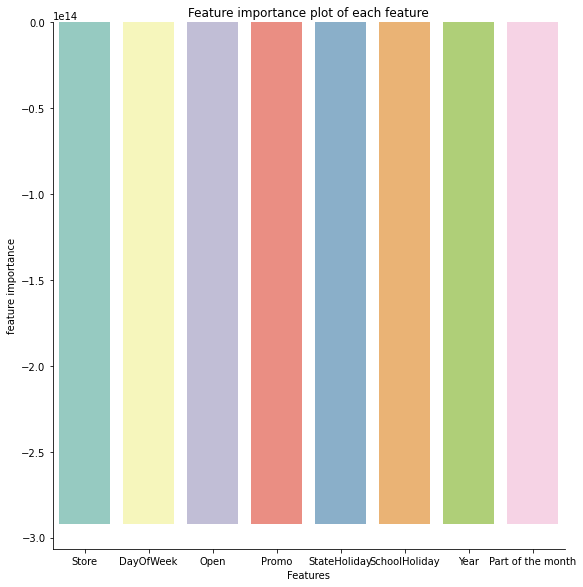

            features      feature_importance
0              Store -291,893,772,791,754.94
1          DayOfWeek -291,893,772,791,754.94
2               Open -291,893,772,791,754.94
3              Promo -291,893,772,791,754.94
4       StateHoliday -291,893,772,791,754.94
5      SchoolHoliday -291,893,772,791,754.94
6               Year -291,893,772,791,754.94
7  Part of the month -291,893,772,791,754.94


In [53]:

# get importance of logistic regression by looking at their weight
features = ["Store","DayOfWeek","Open","Promo","StateHoliday","SchoolHoliday","Year","Part of the month"]
# get importance
importance = trained_model.coef_[0]
feature_df = pd.DataFrame({"features":features,"feature_importance": importance })
# plot feature importance
visualize.catplot(df=feature_df,x="features",y="feature_importance",kind="bar",title="Feature importance plot of each feature",size=8,w_size=12,xlabel="Features",ylabel="feature importance")
print(feature_df)

### We are getting low scores for all the variables